# VET Test - Curl field displacement

In this Jupyter notebook, we will test the Variational Echo Tracking implementation using
reference image and a target image that was morphed using a known displacement field.

The VET should be able to retrieve actual displacement field.


## Load reference image
Lets start by loading a reference image from the scipy package and resizing it to a suitable size:

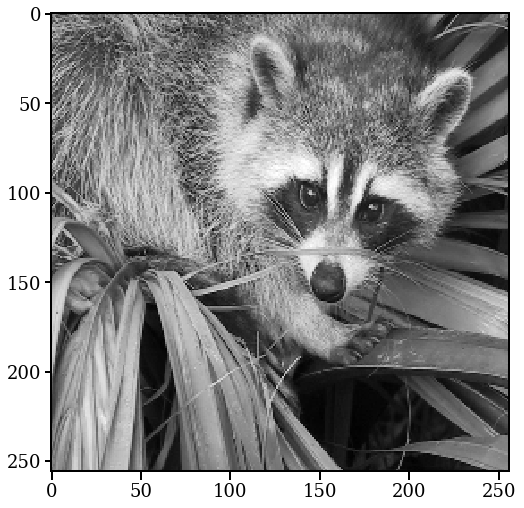

In [12]:
import numpy
from scipy.misc.common import face # import the racoon face image
from skimage import transform 

# Image size to use in the example
imageSize = 16 * 4 * 2 * 2 

# Lets first convert the color image to grey scale
def rgb2gray(rgb):
    """ Function to convert rgb to grey scale"""
    return numpy.dot(rgb[..., :3], [0.299, 0.587, 0.114])

referenceImage = numpy.array(rgb2gray(face()))
                             
# Now resize the image to the desired size                             
referenceImage = transform.resize(referenceImage, (imageSize, imageSize),mode='reflect')


import matplotlib.pyplot as plt
# Set the default configurations for figures to be used in this notebook


# Show reference image
plt.figure(figsize=(8,8))
plt.gray()
plt.imshow(referenceImage)
plt.show()

Lets create an imaginary grid on the image and create a displacement field to apply to the image:

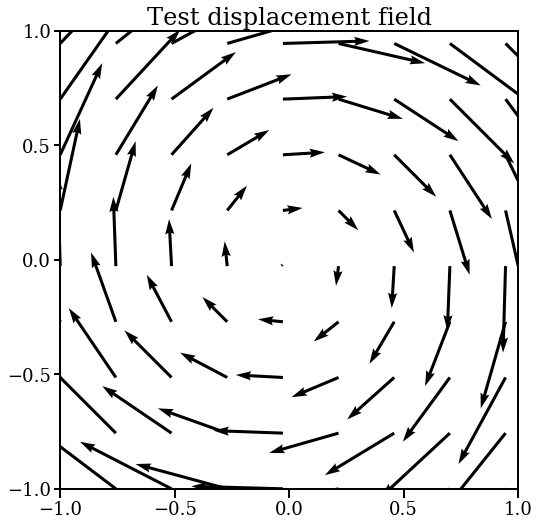

In [4]:
# Set the grid values (x,y) between -1 and 1
positions = numpy.linspace(-1,1,imageSize)
x, y = numpy.meshgrid(positions,
                      positions)

# Create a reference displacement to be applied to the reference image
# A rotor displacement is applied
displacement = numpy.zeros((2, imageSize , imageSize))    

displacement[0, :] = y
displacement[1, :] = -x

displacement *= 2

step = 31

### Set figures default properties
import matplotlib
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 24


plt.close() # Close previous figures if any
plt.figure(figsize=(8,8))

plt.quiver(x[::step, ::step], y[::step, ::step], 
           displacement[0, ::step, ::step], displacement[1, ::step, ::step],
           scale=10)

plt.title("Test displacement field")
plt.gca().set_aspect('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)        
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.show()

## Retrieve displacement field using VET
Now, we apply morph the reference image by appliying the displacement field:    

In [5]:
from pyVET.VET import morph

morphedImage = morph( referenceImage, displacement )


Retrieve the displacement field applied to the image using the VET algorithm.

In [6]:
from pyVET.VET import VET

# Scaling procedure factors
# This means that the algorithm will start the minimization using 2x2 sector displacements,
# then, 4x4, and finally 16x16
factors = [ 2, 4, 8 , 16 ]

newDisplacement,intermediateSteps = VET( referenceImage,
                                         morphedImage, 
                                         factors ,
                                         verbose=True,
                                         intermediateSteps=True,
                                         smoothGain=100)



Sector Shape: (128, 128)
Minimizing
         Current function value: 8240801.162932
         Iterations: 9
         Function evaluations: 721
         Gradient evaluations: 71

Sector Shape: (64, 64)
Minimizing
         Current function value: 2927482.646539
         Iterations: 11
         Function evaluations: 4025
         Gradient evaluations: 118

Sector Shape: (32, 32)
Minimizing
         Current function value: 978301.246756
         Iterations: 9
         Function evaluations: 16653
         Gradient evaluations: 128

Sector Shape: (16, 16)
Minimizing
         Current function value: 355791.142611
         Iterations: 4
         Function evaluations: 19028
         Gradient evaluations: 37


## Show the scaling guess procedure results

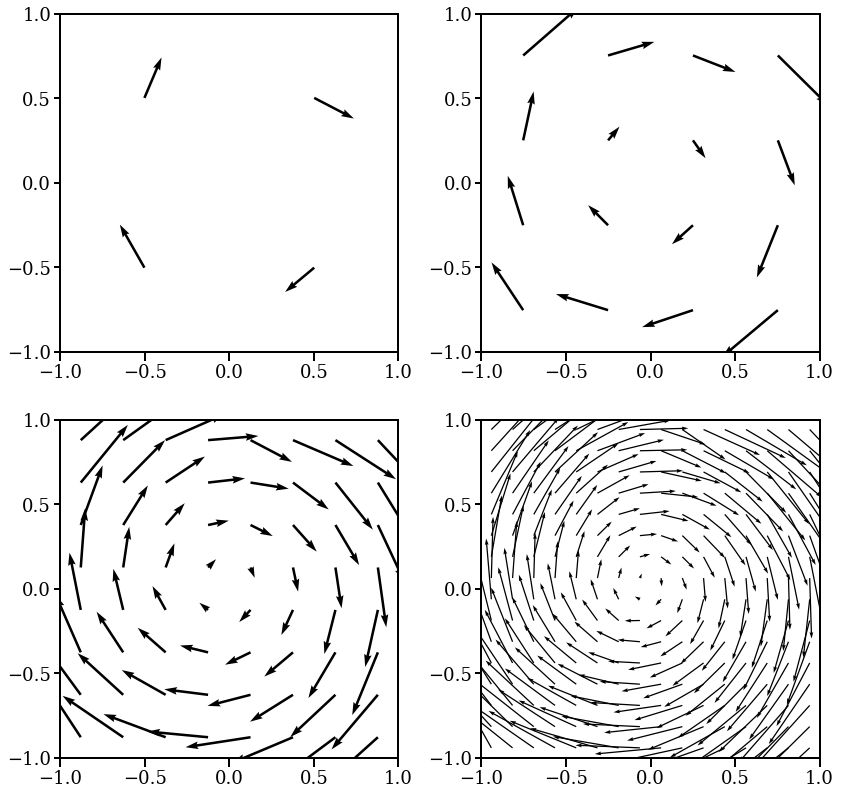

In [7]:
from pyVET.VET import downsize
plt.close()
plt.figure(figsize=(13,13))

for i, firstGuess in enumerate(intermediateSteps):

    factorX = referenceImage.shape[0]/firstGuess.shape[1]
    factorY = referenceImage.shape[1]/firstGuess.shape[2]
    
    # Get the positions of each sector's center
    newX = downsize(x, factorX,yFactor=factorY)
    newY = downsize(y, factorX,yFactor=factorY)
    
    ax = plt.subplot( 221 + i , aspect = 'equal' )
    plt.quiver(newX, newY, firstGuess[0,...],firstGuess[1,...], scale = 10 )
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    
plt.show()

## Compare retrieved displacement field with the applied one

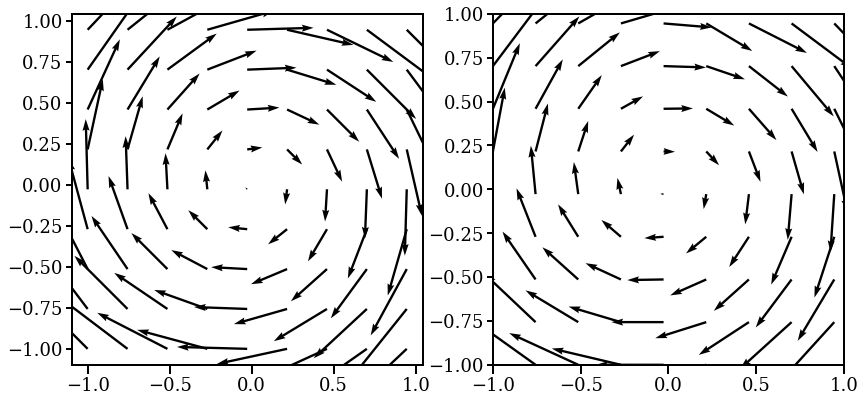

In [10]:
plt.close()
plt.figure(figsize=(13,13))

plt.subplot( 121, aspect = 'equal' )
step = 31
plt.quiver( x[::step,::step], y[::step,::step], 
           displacement[0,::step,::step], 
           displacement[1,::step,::step], scale = 10 )

plt.subplot( 122, aspect = 'equal' )
plt.quiver( x[::step,::step], y[::step,::step], 
           newDisplacement[0,::step,::step], 
           newDisplacement[1,::step,::step], scale = 10 )

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()


The differences in the fields are mostly because the minimization is never carried out in the grid resultion.
The minimum sector size was 16x16 grid points.